# Анализ оттока фитнес-центра

Фитнес-центр разрабатывает стратегию удержания клиентов. Очень часто клиенты перестают пользоваться услугами центра без очевидных признаков, например, по закрытию договора. Руководству организации нужно разработать модель для прогноза оттока клиентов по неочевидным признакам.

**Цель исследования:** провести анализ и кластеризацию клиентов, подготовить план действия по их удержанию.

Данные о клиентах представлены файлом `gym_churn.csv` со следующими полями:
+ `gender` - пол,
+ `Near_Location` - проживание или работа в районе, где находится фитнес-центр,
+ `Partner` - сотрудник компании-партнёра клуба,
+ `Promo_friends` - факт первоначальной записи в рамках акции «приведи друга»,
+ `Phone` - наличие контактного телефона,
+ `Age` - возраст,
+ `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах),
+ `Contract_period` - длительность текущего действующего абонемента (месяц, 6 месяцев, год),
+ `Month_to_end_contract` - срок до окончания текущего действующего абонемента (в месяцах),
+ `Group_visits` - факт посещения групповых занятий,
+ `Avg_class_frequency_total` - средняя частота посещений в неделю за все время с начала действия абонемента,
+ `Avg_class_frequency_current_month` - средняя частота посещений в неделю за все время с начала действия абонемента,
+ `Avg_additional_charges_total` - суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон,
+ `Churn` — факт оттока в текущем месяце.


План исследования:
1. Импорт библиотек и загрузка данных
2. Исследовательский анализ данных
3. Обучение модели прогнозирования оттока клиентов
4. Кластеризация клиентов
5. Выводы и рекомендациии рекомендации

# Импорт библиотек и загрузка данных

Импортируем необходимые для дальнейшей работы библиотеки.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4,5)
import seaborn as sns
sns.set_theme(style = 'white')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools

Сохраним датасет в переменной "df".

In [7]:
df = pd.read_csv('D:/Project/gym_churn.csv')

Выведем первые 5 строк датафрейма на экран.

In [9]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


# EDA

Посмотрим на наличие пропусков в датасете.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В датасете нет пропусков.

Просмотрим информацию о средних значениях и стандартных отклонениях.

In [15]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Посмотрим на средние значения признаков для тех, кто ушел и тех, кто остался.

In [17]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Мы видим, что ушедшие из фитнес-центра клиенты реже оказывались сотрудниками компании-партнёра клуба, среди них меньше пришедших по акции "приведи друга", они имеют в среднем меньшую длительность абонемента, меньше посещали групповые занятия, имеют чуть меньший средний возраст, меньше тратились на дополнительные услуги фитнес-центра, имели меньший срок до окончания абонемента, меньший лайфтаим, меньшую частоту посещений в неделю.

Построим гистограммы и изучим распределения признаков для тех, кто ушел и для тех, кто остался.

In [20]:
#сохраним данные для ушедших и оставшихся клиентов в переменных "churn" и "no_churn" соответствено
churn = df[df['Churn']==1]

In [21]:
no_churn = df[df['Churn']==0]

Построим графики.

Построим столбчатые диаграммы для дискретных величин.
    
Диаграммы будем строить на основе сводной таблицы для каждого признака. Чтобы каждый раз не писать код для создания сводной таблицы и графика, напишем функцию, которая автоматически их создает на основе переданного в аргумент столбца.

In [24]:
def pivot_and_plot (column, text_labels = True):
    if column != 'Partner':
        pivot_table = df.pivot_table (index = column, columns = 'Churn', values = 'Partner', aggfunc = 'count')
    else:
        pivot_table = df.pivot_table (index = column, columns = 'Churn', values = 'gender', aggfunc = 'count')
    # если во втором аргументе указать True, функция переименует столбцы
    if text_labels == True:
        pivot_table = pivot_table.rename(index={0: 'Нет', 1: 'Да'})
    else: 
        pass
    plot = pivot_table.plot(kind = 'bar', figsize = (6,5))
    plt.ylabel('Количество')
    plt.legend(title = 'Факт оттока', labels = ['Нет', 'Да'])
    plt.tick_params('x', rotation = 0)
    return plot

Пол клиента в датасете обозначен цифрами 0 и 1. При этом в описании данных не написано какая цифра к какому полу относится, поэтому оставим как есть.

<Axes: xlabel='gender', ylabel='Количество'>

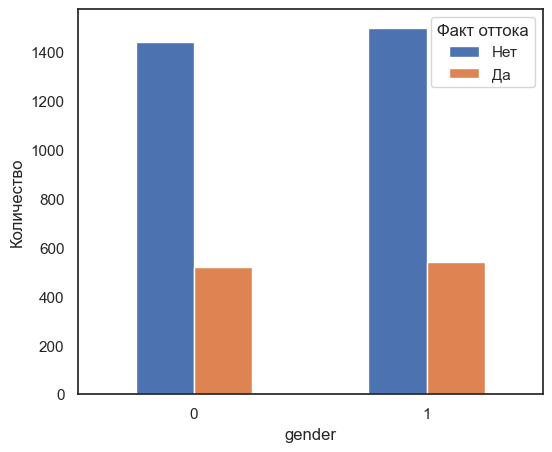

In [26]:
pivot_and_plot('gender', False)
#plt.xlabel('Пол')
#plt.title('Количество клиентов каждого пола')
#plt.show()

<div class="alert alert-block alert-info">
<b>КОММЕНТАРИЙ ОТ УЧЕНИКА: </b> Для большей информативности можно было бы подписи к столбцам изменить с "0" и "1" на "нет" и "да" соответственно, однако модуль выдает ошибку "module 'matplotlib.pyplot' has no attribute 'set_xticks'", поэтому условимся, что "0" означает "нет", а "1" - "да".</div>

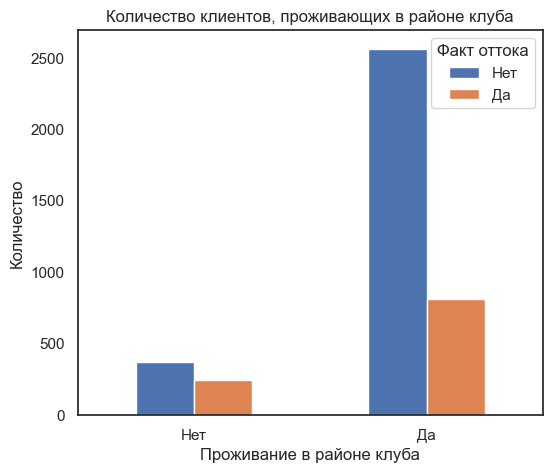

In [28]:
pivot_and_plot('Near_Location')
plt.xlabel('Проживание в районе клуба')
plt.title ('Количество клиентов, проживающих в районе клуба')
plt.show()

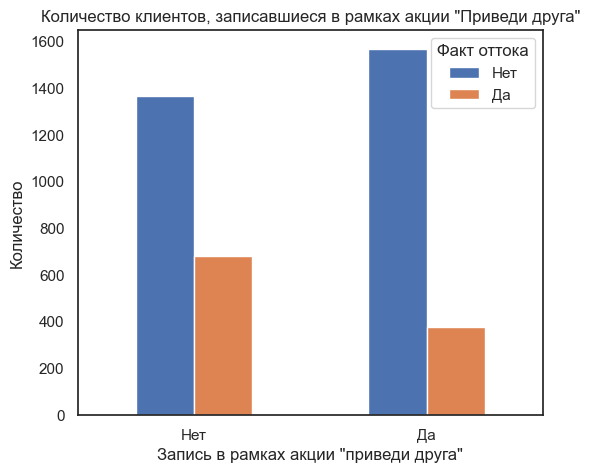

In [29]:
pivot_and_plot('Partner')
plt.xlabel('Запись в рамках акции "приведи друга"')
plt.title ('Количество клиентов, записавшиеся в рамках акции "Приведи друга"')
plt.show()

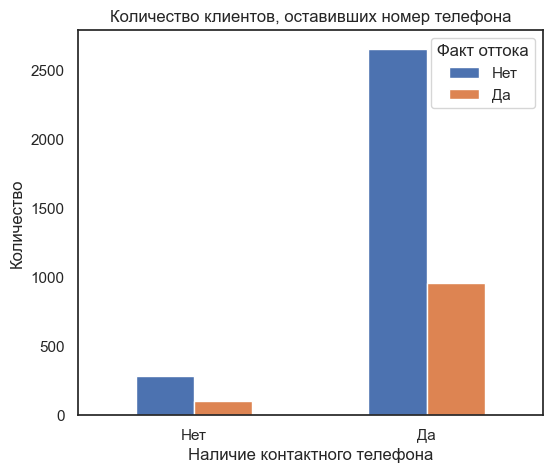

In [30]:
pivot_and_plot('Phone')
plt.xlabel('Наличие контактного телефона')
plt.title('Количество клиентов, оставивших номер телефона')
plt.show()

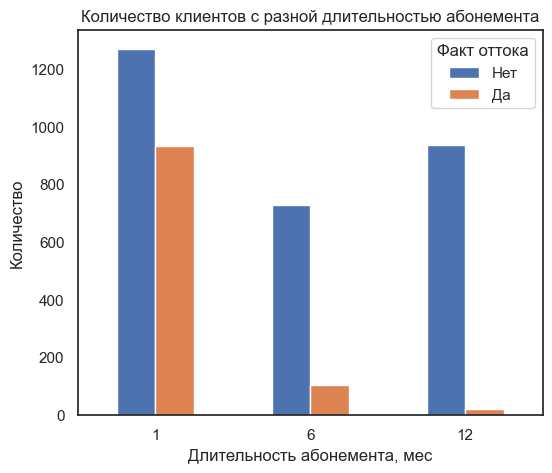

In [31]:
pivot_and_plot('Contract_period', False)
plt.xlabel('Длительность абонемента, мес')
plt.title ('Количество клиентов с разной длительностью абонемента')
plt.show()

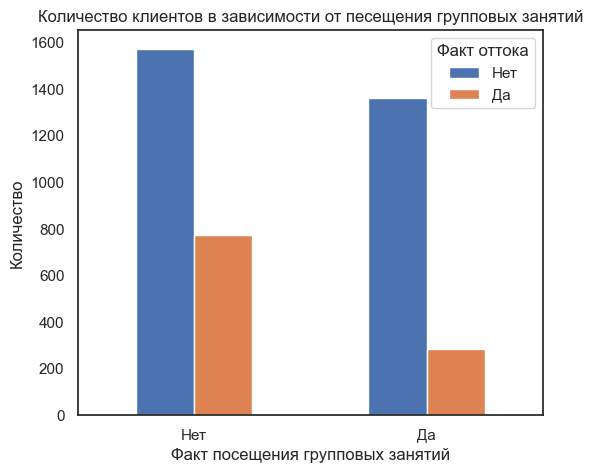

In [32]:
pivot_and_plot('Group_visits')
plt.xlabel('Факт посещения групповых занятий')
plt.title ('Количество клиентов в зависимости от песещения групповых занятий')
plt.show()

In [33]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


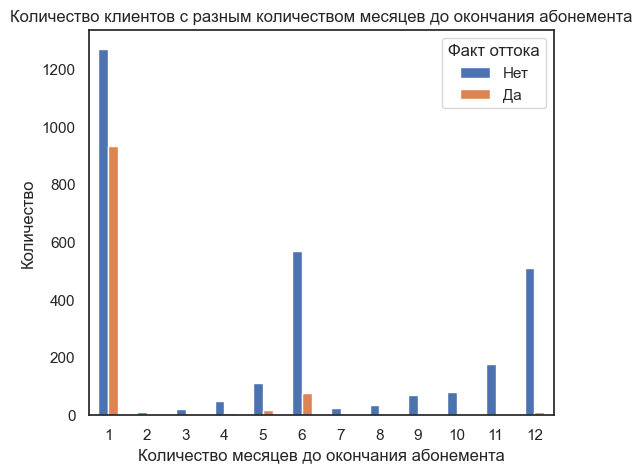

In [34]:
df['Month_to_end_contract'] = df['Month_to_end_contract'].astype('int')
pivot_and_plot('Month_to_end_contract', False)
plt.xlabel('Количество месяцев до окончания абонемента')
plt.title('Количество клиентов с разным количеством месяцев до окончания абонемента')
plt.show()

Построим гистрограммы для непрерывных величин. Совместим на одном графике гистограммы для ушедших клиентов и оставшихся.

In [36]:
# чтобы каждый раз не писать код для 2-х гистограмм и повторяющихся параметров для каждого признака, напишем функцию,
# которой на вход достаточно передать название столбца, по которому строим график
def hist(column):
    ax = no_churn[column].hist(figsize = (5,5),bins = 20)
    churn[column].hist(ax = ax, figsize = (5,5), bins = 20)
    plt.legend(title = 'Факт оттока',labels = ['Нет','Да'])
    plt.ylabel('Количество')

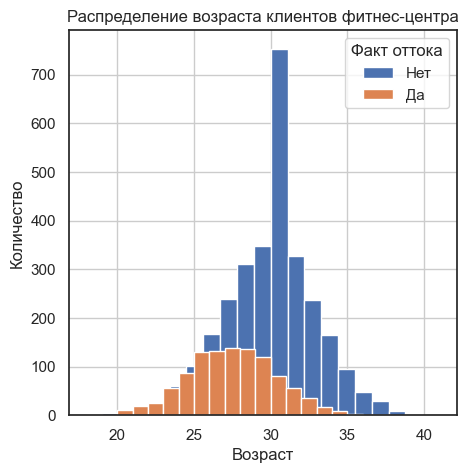

In [37]:
hist('Age')
plt.xlabel('Возраст')
plt.title('Распределение возраста клиентов фитнес-центра')
plt.show()

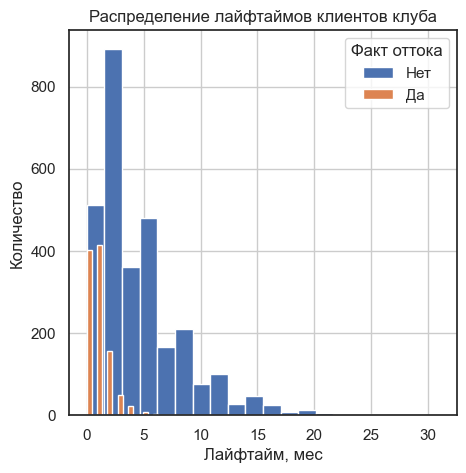

In [38]:
hist('Lifetime')
plt.xlabel('Лайфтайм, мес')
plt.title('Распределение лайфтаймов клиентов клуба')
plt.show()

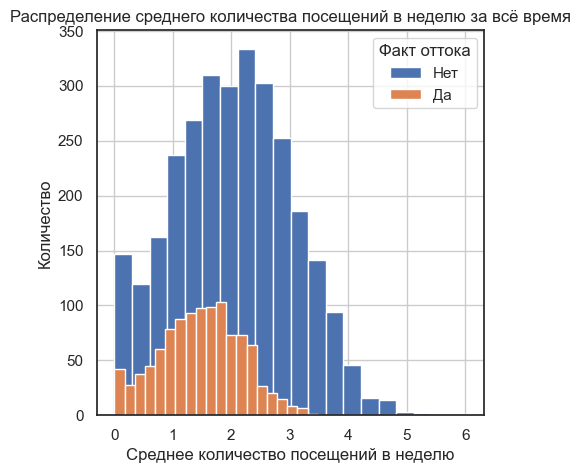

In [39]:
hist('Avg_class_frequency_total')
plt.xlabel('Среднее количество посещений в неделю')
plt.title('Распределение среднего количества посещений в неделю за всё время')
plt.show()

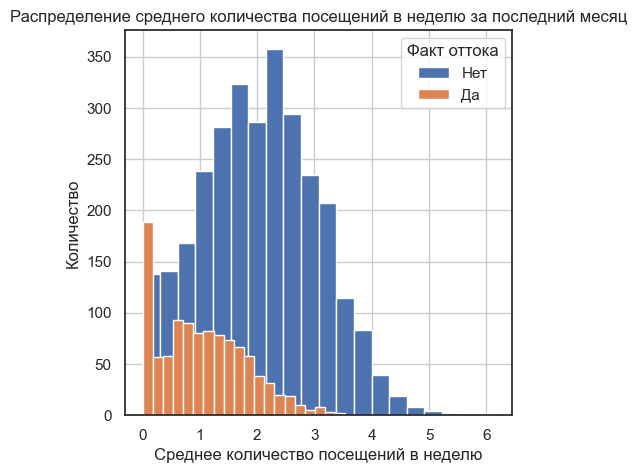

In [40]:
hist('Avg_class_frequency_current_month')
plt.xlabel('Среднее количество посещений в неделю')
plt.title('Распределение среднего количества посещений в неделю за последний меcяц')
plt.show()

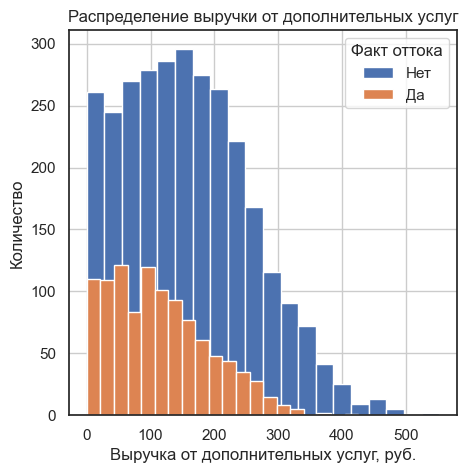

In [41]:
hist('Avg_additional_charges_total')
plt.xlabel('Выручка от дополнительных услуг, руб.')
plt.title('Распределение выручки от дополнительных услуг')
plt.show()

Здесь мы видим, что у оставшихся клиентов, в отличии от ушедших, выше доля сотрудников компаний-партнеров клуба. Также в 2 раза выше доля пришедших по программе "приведи друга". Длительность абонемента равна 1, 6 и 12 месяцам (в отличии от ушедших клиентов, где длительность в основном равна только 1 месяцу). У оставшихся пользователей выше доля посещающих групповые занятия, до окончания действующего абонемента больше времени, выше лайфтайм, они чаще посещают занятия.

Также стоит обратить внимание, что у ушедших пользователей, частота посещений в последнем месяце часто равна нулю.

Построим матрицу корреляций и визуализируем ее с помощью тепловой карты.

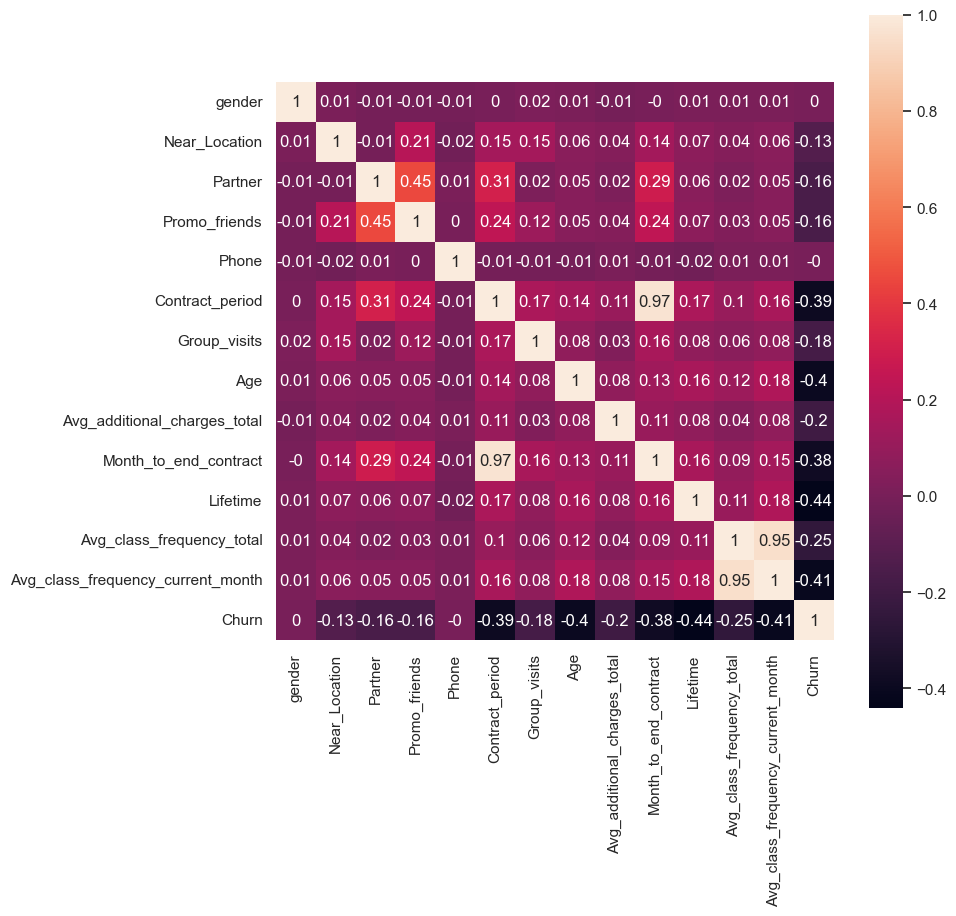

In [44]:
df_corr = df.corr().round(2)
plt.figure(figsize = (9,9))
sns.heatmap(df_corr, annot=True, square = True)
plt.show()

Параметры "month_to_end_contract" и "contract period", а также "Avg_class_frequency_current_month" и "Avg_class_frequency_total" имеют между собой высокий уровень корреляции, что может усложнить построение модели.

Столбец "Churn" коррелирует с такими параметрами как длительность абонемента, возраст, время до окончания абонемента, лайфтайм, частота посещений в текущем месяце.

Уберем из датафрейма по одному из двух пар мультиколлинеарных признаков.

In [47]:
df = df.drop(['Month_to_end_contract','Avg_class_frequency_total'],axis = 1)

In [48]:
df.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Lifetime',
       'Avg_class_frequency_current_month', 'Churn'],
      dtype='object')

В ходе исследовательского анализа данных были исследованы распределения признаков. Были обнаружены отличия в признаках для ушедших и оставшихся клиентов, например, для таких параметров как принадлежность к компании-партнеру клуба, лафйтайм, длительность абонемента и другие.
Была построена матрица корреляций признаков. Признаки "Month_to_end_contract" и "Avg_class_frequency_total" были исключены из анализа из-за их высокой корреляции с признаками "month_to_end_contract" и "avg_class_frequency_total" соответственно.

## Обучение модели прогнозирования оттока клиентов

Обучение модели логистической регрессии и случайного леса для прогноза оттока клиентов.

Проведем разделение выборки на обучающую и валидационную.

In [53]:
# разделим признаки и целевую переменную
x = df.drop(['Churn'], axis = 1)
y = df['Churn']

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

Для дальнейшего построения модели логистической регрессии необходимо стандартизировать значения.

In [56]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

Приступим к обучению модели логистической регресии.

In [58]:
model = LogisticRegression()
model.fit(x_train_st, y_train)
# сохраним вектор спрогнозированных значений в переменной
y_pred_regression = model.predict(x_test_st)

Обучим модель с помощью алгоритма "Случайный лес".

In [60]:
rf_model = RandomForestClassifier(n_estimators = 100)
# "деревья" не требуют стандартизации значений, поэтому можно передать на обучение переменную "x_train"
rf_model.fit(x_train, y_train)
# сохраним вектор спрогнозированных значений в переменной
y_pred_forest = rf_model.predict(x_test)

Сравним модели по метрикам accuracy, precision и recall.

Посчитаем метрику accuracy поочередно для модели логистической регрессии, а затем для случайного леса.

In [63]:
regression_accuracy = accuracy_score(y_test, y_pred_regression)
forest_accuracy = accuracy_score(y_test,y_pred_forest)
print(f'Метрика accuracy для модели логистической регрессии составляет {regression_accuracy}, \nМетрика accuracy для модели случайного леса составляет {forest_accuracy}')

Метрика accuracy для модели логистической регрессии составляет 0.9025, 
Метрика accuracy для модели случайного леса составляет 0.89125


Значение метрики в обоих моделях практически одинаково высоко. Это значит, что модели в ~90% случаев сделали верный прогноз.

Узнаем значения метрики precision.

In [66]:
regression_precision = precision_score(y_test, y_pred_regression)
forest_precision = precision_score(y_test, y_pred_forest)
print(f'Метрика precision для модели логистической регрессии составляет {round(regression_precision,3)}, \nМетрика precision для модели случайного леса составляет {round(forest_precision,3)}')

Метрика precision для модели логистической регрессии составляет 0.791, 
Метрика precision для модели случайного леса составляет 0.807


Обе метрики высоки и равны ~80%. Это означает, что среди всех спрогнозированных моделями ушедших клиентов (churn = 1), 80% спрогнозированы верно.

На данном шаге мы обучили алгоритмы логистической регрессии и случайного леса делать прогноз перестанет ли клиент пользоваться услугами фитнес-центра или останется в нем.

# Кластеризация клиентов

Построим матрицу расстояний признаков

In [71]:
linked = linkage(x_train_st, method = 'ward')

Визуализируем матрицу расстояний с помощью дендрограммы.

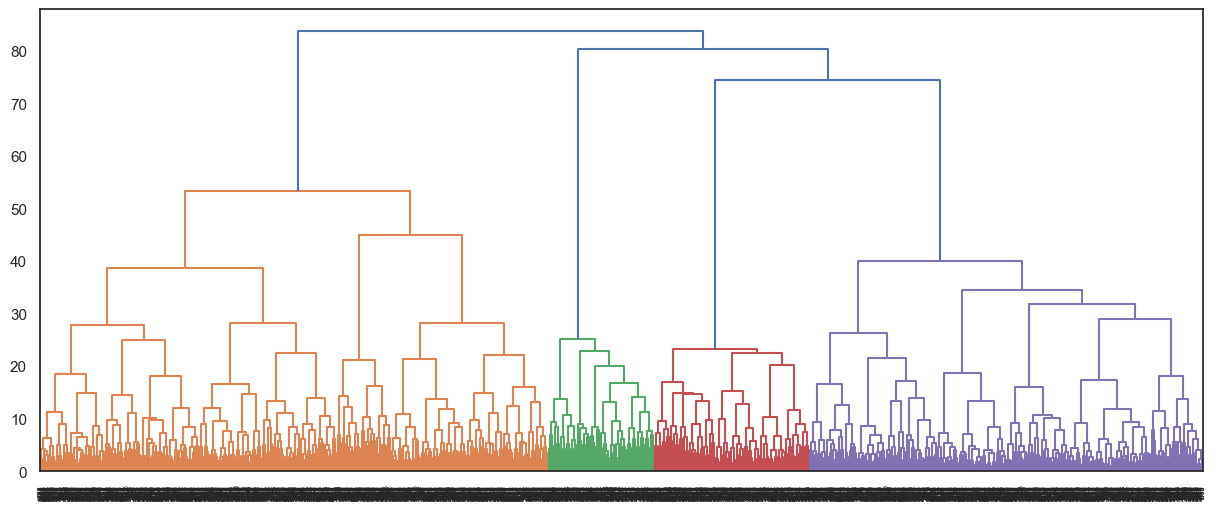

In [73]:
plt.figure(figsize = (15,6))
dendrogram(linked, orientation = 'top')
plt.show()

На основании дендрограммы можно выделить 4 кластера.

Сделаем кластеризацию клиентов алгоритмом KMeans.

In [76]:
x_sc = scaler.fit_transform(df.drop(['Churn'], axis = 1))
# в условии задачи прописано количество кластеров равное 5
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(x_sc)

In [77]:
# добавим индексы кластеров в исходный датафрейм
df['cluster'] = labels

Проверим успешность добавления массива в датафрейм.

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Lifetime                           4000 non-null   int64  
 10  Avg_class_frequency_current_month  4000 non-null   float64
 11  Churn                              4000 non-null   int64

In [80]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0,2
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0,1
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0,2
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0,2


In [81]:
df.tail()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn,cluster
3995,1,1,1,0,1,12,0,33,2.406023,8,2.349070,0,1
3996,0,1,0,0,1,1,1,29,68.883764,1,0.292859,1,0
3997,1,1,1,1,1,12,0,28,78.250542,2,2.831439,0,2
3998,0,1,1,1,1,6,0,32,61.912657,3,1.596237,0,2
3999,1,0,1,0,0,12,1,30,178.861814,1,1.035270,0,3


Столбец успешно добавлен, потерь данных нет.

Посмотрим на средние значения признаков кластеров.

In [84]:
df.groupby('cluster').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,
0,0.488372,1.000000,0.189624,0.071556,0.899821,1.820215,0.274597,27.516100,119.280256,1.949016,1.201961,0.582290
1,0.553590,1.000000,0.405827,0.007284,0.926119,6.570239,0.540062,30.802289,177.136345,3.533819,2.302468,0.032258
2,0.489855,0.995169,0.902415,1.000000,0.899517,6.965217,0.520773,29.590338,152.705310,3.728502,1.886617,0.129469
3,0.498333,0.000000,0.495000,0.075000,0.911667,2.963333,0.226667,28.681667,137.139130,2.778333,1.594682,0.408333
4,0.548951,0.951049,0.398601,0.234266,0.839161,4.856643,0.517483,29.853147,153.349944,13.279720,2.105894,0.000000


У кластеров можно выделить следующие признаки.

Проживание/работа в районе фитнес-центра. У кластера с индексом 1 никто из клиентов не живет/работает рядом. В кластер 4, напротив, попали только клиенты, живущие/работающие в районе фитнес-центра. Остальные кластеры имеют высокое среднее значение попадания в данный признак.

Запись в рамках акции "приведи друга". В кластер 0 попали только клиенты, которые пришли по этой акции. Кластеры 1, 2 и 3 имеют низкую долю попадания клиентов в этот признак.

Наличие контактного телефона. В кластер 4 попали все клиенты, о номере телефона которых нет данных.

Построим распределения признаков для кластеров для наглядной визуализации отличий признаков для кластеров.

Построим отдельно распределения сначала для категориальных признаков, затем для количественных.

In [88]:
# сохраним количетвенные и категориальные признаки в отдельной переменной
df_numerical = df[['Age','Lifetime','Avg_class_frequency_current_month','Avg_additional_charges_total']]

In [89]:
# Длительность абонемента визуализируем отдельно
df_categorical = df.drop(columns = df_numerical.columns).drop(['Contract_period'],axis = 1)

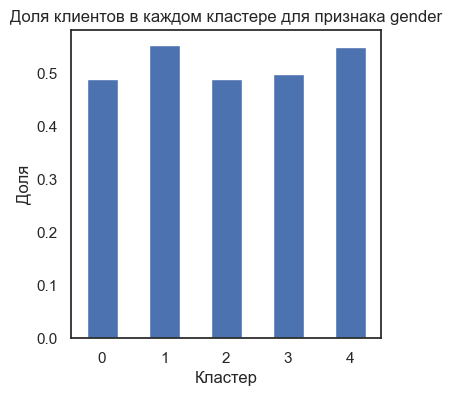

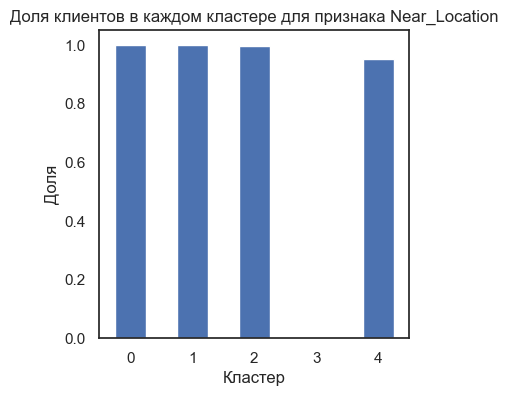

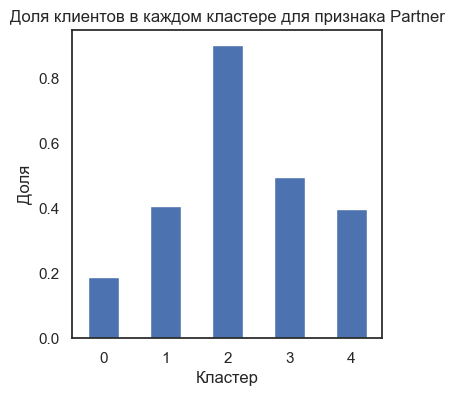

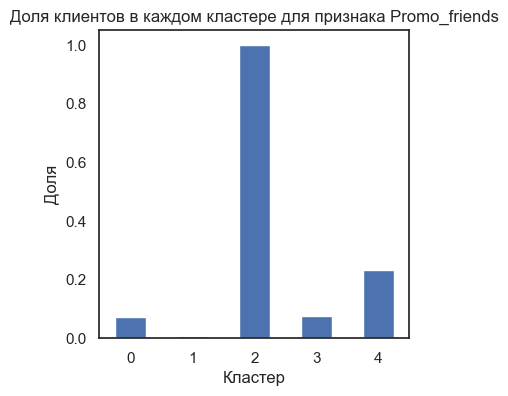

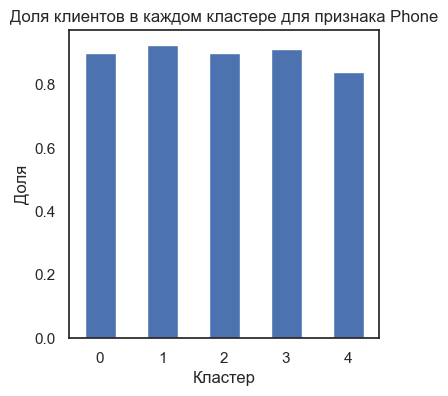

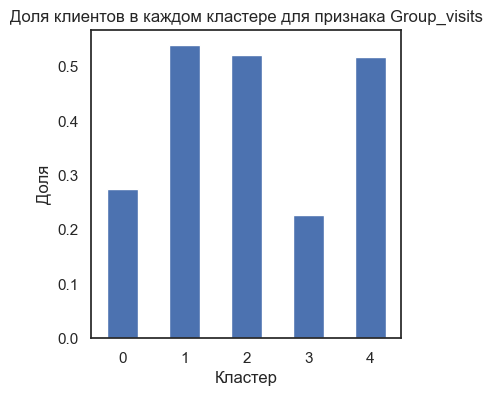

In [90]:
for column in df_categorical.columns:
    if column != 'cluster' and column != 'Churn':
        df_categorical.groupby('cluster')[column].mean().plot(kind = 'bar', y = column, figsize = (4,4))
        plt.xlabel('Кластер')
        plt.ylabel('Доля')
        plt.title(f'Доля клиентов в каждом кластере для признака {column}')
        plt.xticks(rotation = 0)
        plt.legend().remove()
        plt.show()

Кроме перечисленных ранее признаков, можно выделить такие признаки как "сотрудник компании-партнера клуба" (в кластере 2 малая доля клиентов, принадлежащих данному кластеру, в кластере 0, напротив, высокая), "факт посещения групповых занятий" (в кластере 1 и 2 низкая доля клиентов, обладающих данным признаком)

Визуализируем кластеры по длительности абонемента.

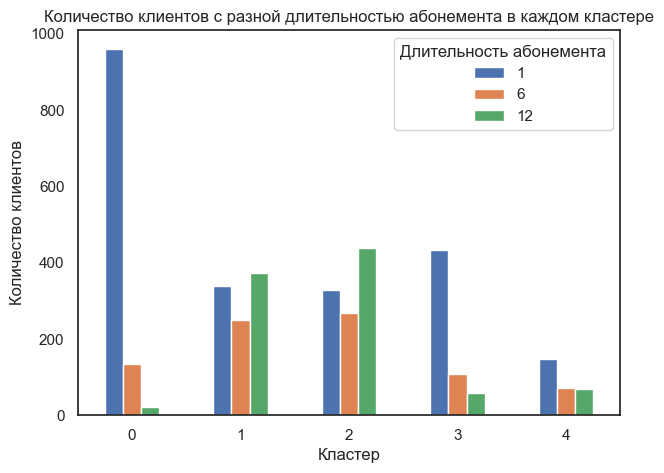

In [93]:
period_pivot = df.pivot_table(index = 'cluster', columns = 'Contract_period', values = 'Age', aggfunc = 'count')
period_pivot.plot(kind = 'bar', figsize = (7,5))
plt.xlabel('Кластер')
plt.ylabel('Количество клиентов')
plt.legend(title = 'Длительность абонемента')
plt.tick_params(labelrotation = 0)
plt.title('Количество клиентов с разной длительностью абонемента в каждом кластере')
plt.show()

У кластеров 1 и 2 преобладают клиенты с абонементом с длительностью в месяц. 12-месячных абонементов больше всего в кластерах 0 и 3.

Построим распределения для количественных признаков с помощью диаграмм рассеяния. Чтобы не писать код для каждой пары признаков отдельно, определим функцию отрисовки графиков попарных признаков для кластеров и отрисуем с помощью цикла for.

In [96]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x = df[x_name], y = df[y_name], hue=df[cluster_name], palette = 'deep', alpha = 0.76)
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

In [97]:
col_pairs = list(itertools.combinations(df_numerical.columns, 2))

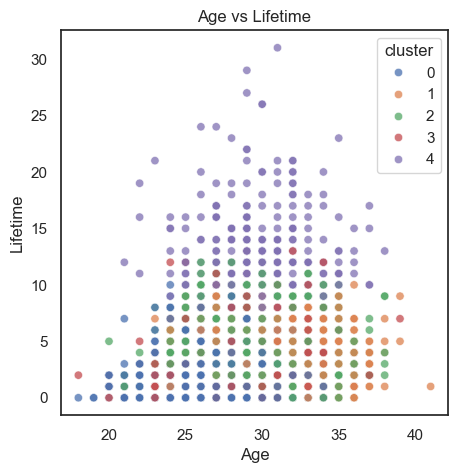

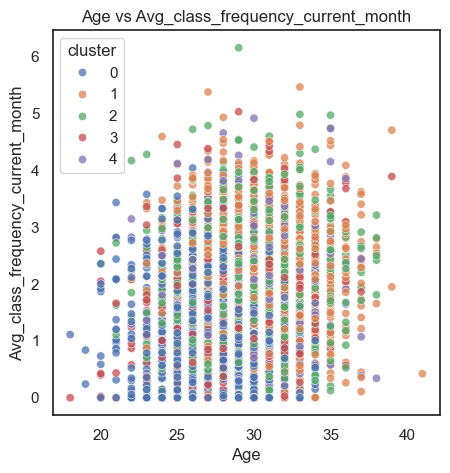

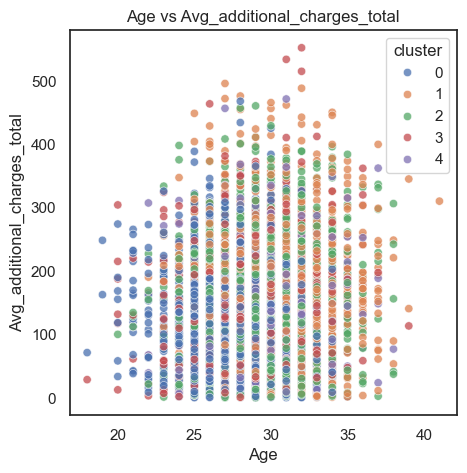

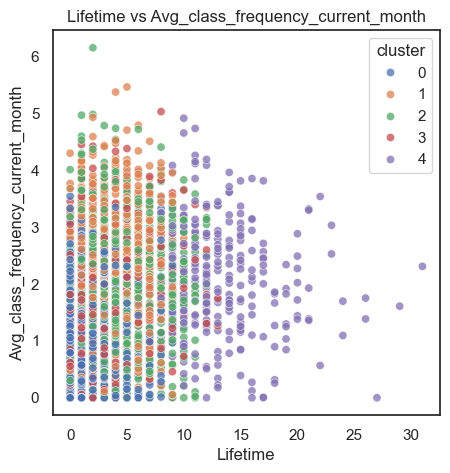

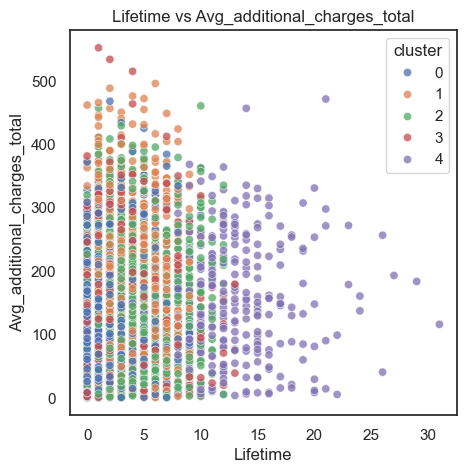

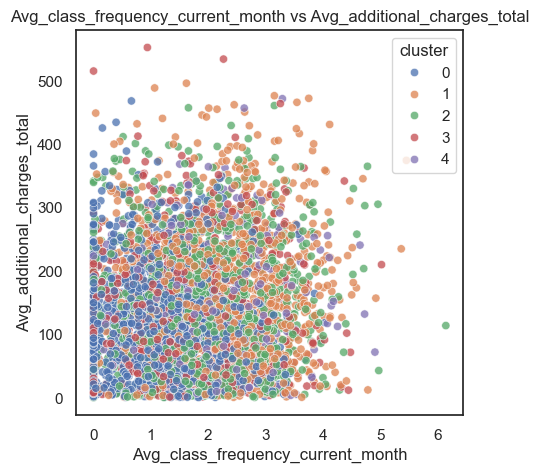

In [98]:
for p in col_pairs:
    show_clusters_on_plot (df,p[0],p[1],'cluster')

На данных диаграммах рассеяния можно увидеть разницу между кластером 2 и кластером 3. Клиенты кластера 2, как правило, более молодые и имеют меньший лайфтайм, по сравнению с клиентами кластера 3, склонны к меньшей частоте посещения занятий в месяц.

Посчитаем и визуализируем долю оттока для каждого кластера.

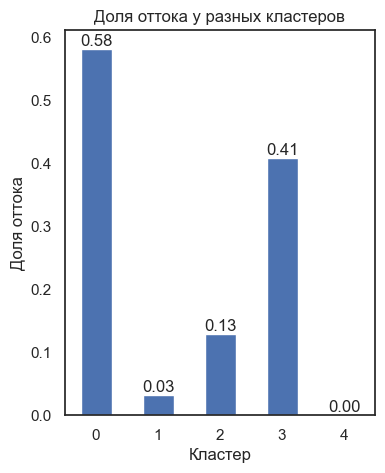

In [101]:
clusters_churn = df.groupby('cluster')['Churn'].mean()
bar = clusters_churn.plot(kind = 'bar')
plt.xlabel('Кластер')
plt.ylabel('Доля оттока')
plt.title('Доля оттока у разных кластеров')
plt.bar_label(bar.containers[0],fmt='%.2f')
plt.xticks(rotation = 0)
plt.show()

Кластер 3 имеет самую низкую долю оттока: всего 1% клиентов данного кластера перестали ходить в фитнес-центр. Также низкую долю оттока имеет кластер 0.
Самую высокую долю оттока имеет кластер 2: 56% клиентов данного кластера перестали посещать фитнес-центр. Также довольно высокую долю оттока имеет кластер 1.

На данном шаге мы провели кластеризацию клиентов с помощью агломеративной иерархической кластеризации и алгоритма K-Means. Первый алгоритм выделил 4 группы клиентов. Алгоритмом K-Means мы выделили 5 кластеров, среди которых выделяются кластеры 2 и 1 высокой долей оттока, 3 и 0 - низкой.

# Выводы и рекомендации

В ходе работы была проведена предобработка данных, в ходе которой из датафрейма были удалены столбцы с информацией о количестве месяцев до окончания абонемента и среднем количестве посещений в неделю за всё время в следствие их высокой корреляции со столбцами с информацией о длительности абонемента и среднем количестве посещений в неделю за последний месяц.

Для прогноза оттока были обучены 2 модели, которые показали высокий уровень метрик accuracy и precision.
Была проведена кластеризация клиентов с помощью иерархической кластеризации и алгоритмом K-Means.

Рекомендации: увеличить количество компаний-партнеров клуба (т.к. кластер с самым высоким уровнем оттока имел низкую долю клиентов, работающих с партнерами), разработка выгодных долгосрочных абонементов (т.к. клиенты часто не продлевают свой одномесячный абонемент), сделать выгодные предложения для молодых клиентов (например, скидка по студенческому билету), распространение промо-кодов акции "Приведи друга" (т.к. кластер 0 с низкой долей оттока попали клиенты, записавшиеся в рамках этой акции). 